In [1]:
# Workaround for Mac installation issue
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
import pandas as pd
url = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv'
df = pd.read_csv(url, encoding="cp1252")

### Raw Data

In [3]:
df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,28/03/2020,28,3,2020,16,1,Afghanistan,AF,AFG,37172386.0
1,27/03/2020,27,3,2020,0,0,Afghanistan,AF,AFG,37172386.0
2,26/03/2020,26,3,2020,33,0,Afghanistan,AF,AFG,37172386.0
3,25/03/2020,25,3,2020,2,0,Afghanistan,AF,AFG,37172386.0
4,24/03/2020,24,3,2020,6,1,Afghanistan,AF,AFG,37172386.0


## Cleanup and Convert Dates

In [4]:
df['report_date'] = df.apply(lambda r: pd.to_datetime(f"{r['year']}-{r['month']}-{r['day']}"), axis=1)

### Clean up 
Removing unwanted and rename columns

In [5]:
# Drop columns
df = df.drop(columns=['dateRep', 'day', 'month', 'year'])
# Reorder columns
df = df[['report_date', 'countryterritoryCode', 'cases', 'deaths']]
# Rename columns
df = df.rename(columns={'countryterritoryCode': 'country_territory_code'})

### Data Prepared

In [6]:
df.head()

,report_date,country_territory_code,cases,deaths
0,2020-03-28,AFG,16,1
1,2020-03-27,AFG,0,0
2,2020-03-26,AFG,33,0
3,2020-03-25,AFG,2,0
4,2020-03-24,AFG,6,1


## Death Rate Analysis

Cumulative death Count by Country starting with 10th death in each country

In [7]:
# Calculate cumulative by Country
df = (df.assign(total=df.sort_values(['report_date'], ascending=True).groupby(['country_territory_code']).deaths.cumsum()))
# Filter out below 10 deaths
df = df.where(df['total'] > 10).dropna()

### Result

In [8]:
df.head()

,report_date,country_territory_code,cases,deaths,total
121,2020-03-28,ARG,101.0,105.0,117.0
122,2020-03-27,ARG,87.0,4.0,12.0
137,2020-03-28,DZA,0.0,0.0,21.0
138,2020-03-27,DZA,41.0,4.0,21.0
139,2020-03-26,DZA,33.0,0.0,17.0


### Determine start date by country

Locate the date of the date of the 10th death by Country

In [9]:
country_start = df.groupby('country_territory_code').report_date.min()
country_start = country_start.to_frame().rename(columns={'report_date': 'start_date'})

In [10]:
country_start.head()

,start_date
country_territory_code,
ARG,2020-03-27
AUS,2020-03-27
AUT,2020-03-23
BEL,2020-03-19
BRA,2020-03-21


### Deteremine the number of days since start

Join the start_date with the main data frame and base on days into pandemic

In [11]:
# Join start date
df = df.join(country_start, on='country_territory_code')
# determine number of days into pandemic
df['days_in'] = df.apply(lambda r: (r.report_date - r.start_date).days, axis=1)

In [12]:
df.head()

,report_date,country_territory_code,cases,deaths,total,start_date,days_in
121,2020-03-28,ARG,101.0,105.0,117.0,2020-03-27,1
122,2020-03-27,ARG,87.0,4.0,12.0,2020-03-27,0
137,2020-03-28,DZA,0.0,0.0,21.0,2020-03-23,5
138,2020-03-27,DZA,41.0,4.0,21.0,2020-03-23,4
139,2020-03-26,DZA,33.0,0.0,17.0,2020-03-23,3


## Plot

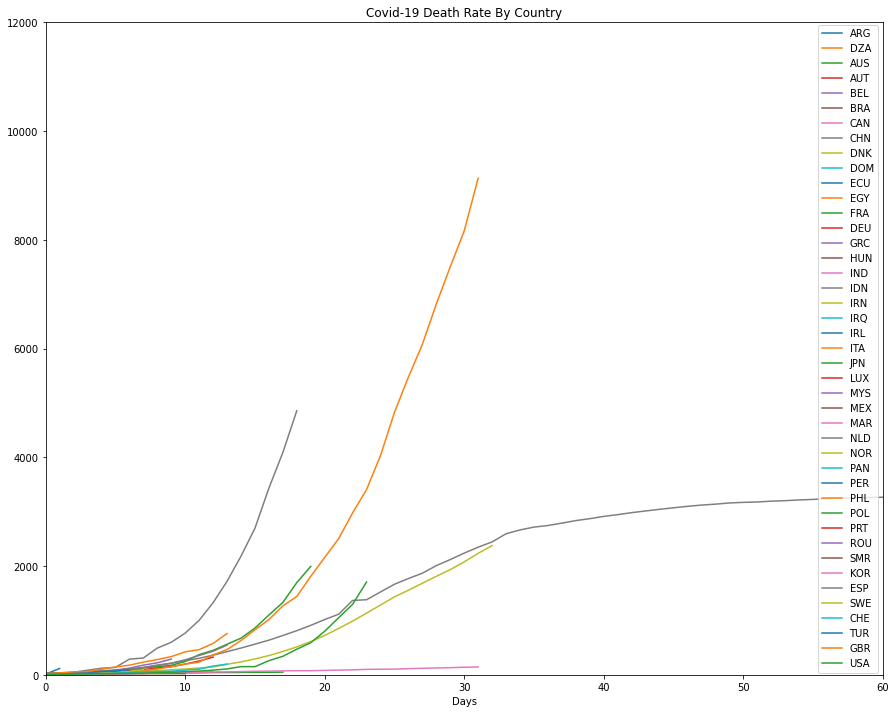

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 12))
ax = plt.axes()

# determine list of countries
countries = df['country_territory_code'].drop_duplicates().to_list()

for country in countries:
    data = df.where(df['country_territory_code'].str.startswith(country))\
        .dropna().sort_values(['report_date'], ascending=True)
    ax.plot(data['days_in'], data['total'], label=country)

ax.legend(loc='right')
plt.xlim(0, 60)
plt.ylim(0, 12000)
ax.set_title('Covid-19 Death Rate By Country')
plt.xlabel('Days')
plt.show()